In [1]:
from matplotlib.pyplot import figure
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:


figure(figsize=(16, 8))
#plt.gca().set_aspect('equal')

def detect_lines(image_path):
    # Load the image
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    img = cv2.medianBlur(img,5)
    
    # Define color range for gold and silver objects
    lower_gold = np.array([5, 50, 40])   # Lower bound for gold in HSV
    upper_gold = np.array([40, 255, 255]) # Upper bound for gold in HSV
    lower_silver = np.array([0, 0, 120])  # Lower bound for silver (bright regions)
    upper_silver = np.array([180, 50, 255]) # Upper bound for silver
    
    # Create masks
    mask_gold = cv2.inRange(hsv, lower_gold, upper_gold)
    mask_silver = cv2.inRange(hsv, lower_silver, upper_silver)
    mask = cv2.bitwise_or(mask_gold, mask_silver)
    
    # Apply mask to remove shadows
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    gray = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
    
    # Apply median blur to reduce noise
    blurred = cv2.medianBlur(gray, 5)
    
    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred, 100, 200)
    
    # Dilate edges to close small gaps
    kernel = np.ones((3, 3), np.uint8)
    edges_dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Erode edges to restore original thickness
    edges_closed = cv2.erode(edges_dilated, kernel, iterations=1)
    
    # Detect contours
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area constraints
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if 0.01 * img.shape[0] * img.shape[1] <= area:
            filtered_contours.append(contour)
    
    # Create a copy of the original image to draw contours
    img_contours = img.copy()
    cv2.drawContours(img_contours, filtered_contours, -1, (0, 0, 255), 1)
    cv2.imwrite("contourtest.jpg", masked_img)
    return
    
    if len(filtered_contours) > 30:
        return
    print("passed")
    
    # Function to find the longest true edge with weighted straightness penalty
    # TODO: Also this takes a while on lots of verticies cause O(n^2) see if we can speed it up
    def find_longest_straight_edge(contour, threshold=0.5):
        max_length = 0
        longest_line = None
        points = contour.reshape(-1, 2)
        
        for i in range(len(points) - 1):
            for j in range(i + 1, len(points)):
                x1, y1 = points[i]
                x2, y2 = points[j]
                length = np.linalg.norm([x2 - x1, y2 - y1])
                
                if length > max_length:
                    # Fit a line and compute perpendicular distances
                    vx, vy, cx, cy = cv2.fitLine(points[i:j+1], cv2.DIST_L2, 0, 0.01, 0.01)
                    distances = np.abs((vx * (points[i:j+1, 1] - cy)) - (vy * (points[i:j+1, 0] - cx)))
                    
                    # Apply a weight function that penalizes deviations near the ends more
                    num_points = len(distances)
                    weights = np.linspace(0, 1.0, num_points)**4 + np.linspace(1.0, 0, num_points)**4
                    weighted_mean_distance = np.average(distances, weights=weights)
                    
                    if weighted_mean_distance < threshold:  # Check if edge is sufficiently straight
                        max_length = length
                        longest_line = (x1, y1, x2, y2)
        
        return longest_line
    
    # Find and draw the longest straight edge for each contour
    for contour in filtered_contours:
        longest_line = find_longest_straight_edge(contour)
        if longest_line:
            x1, y1, x2, y2 = longest_line
            cv2.line(img_contours, (x1, y1), (x2, y2), (255, 0, 0), 1)
            
            # Extend line to edges of the image
            height, width = img.shape[:2]
            m = (y2 - y1) / (x2 - x1 + 1e-6)  # Avoid division by zero
            y_start = int(m * (-x1) + y1)
            y_end = int(m * (width - x1) + y1)
            cv2.line(img_contours, (0, y_start), (width - 1, y_end), (255, 0, 0), 1)

            # Why does contour just have an empty dimension? lol.
            x0 = contour[:,0,0]
            y0 = contour[:,0,1]

            # Find distance between points and our line, dont abs to preserve direction
            # https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
            distance = (((y2-y1)*x0)-((x2-x1)*y0)+(x2*y1)-(y2*x1))/np.sqrt(((y2-y1)**2) + ((x2-x1)**2))
            t = (((x2-x1)*(x0-x1)) + ((y2-y1)*(y0-y1))) / (((x2-x1)**2) + ((y2-y1)**2))

            if abs(np.min(distance)) > np.max(distance):
                distance = -distance

            # Roll so highest peak is at the start/end
            shift = -np.argmax(distance)
            distance = np.roll(distance, shift)
            t = np.roll(t,shift)

            # Find first and last negative values to determine which side is longer
            firstNegative = len(distance)
            lastNegative = 0
            for i in range(len(distance)):
                if distance[i] <= 0:
                    lastNegative = i
                    if firstNegative == len(distance):
                        firstNegative = i

            # Keep only longer side i.e. the one that will have cuts
            if firstNegative > (len(distance) - lastNegative):
                distance = distance[:firstNegative][::-1]
                t = t[:firstNegative][::-1]
            else:
                distance = distance[lastNegative:]         
                t = t[lastNegative:]       

            cuts = []

            i = 0
            for pin in range(5):
                # TODO: adjust these windows so they can't slowly slide upward/downward
                # Find next local maxima
                while i < len(distance)-1:
                    if distance[i] > distance[i+1]+0.25:
                        break
                    i += 1
                
                # Find next local minima
                while i < len(distance)-1:
                    if distance[i]+0.25 < distance[i+1]:
                        break
                    i += 1

                cuts.append(i)

                
            plt.plot(t,distance)
            plt.scatter(t[cuts],distance[cuts])
            gap = np.mean(np.diff(t[cuts]))
            height_t = t[cuts[len(cuts)-1]] + gap
            height = 0
            
            for i in range(len(t)-1):
                #print(t[i],height_t,t[i+1])
                # We have no guarantee on the ordering of t
                if (t[i] <= height_t and height_t <= t[i+1]) or (t[i] >= height_t and height_t >= t[i+1]):
                    height = distance[i]
            #print(height)
            #print(cuts)
            #print(t[cuts])

            mm = (distance[cuts] / height) * 8.51
            code = (((1 - (distance[cuts] / height)) * 8.51)/0.38)
            rounded = np.round(code)
            print(rounded[::-1])

            cid = 0
            for cut in cuts:
                #print(t[cut])
                #print(distance[cut])
                linex = (x2-x1)*t[cut]+x1
                liney = (y2-y1)*t[cut]+y1
                plusx = distance[cut] * (y2-y1) / np.sqrt(((x2-x1)**2) + ((y2-y1)**2))
                plusy = distance[cut] * -(x2-x1) / np.sqrt(((x2-x1)**2) + ((y2-y1)**2))
                cv2.line(img_contours,(int(linex), int(liney)),(int(linex+plusx),int(liney+plusy)),(0,255,255),2)
                image = cv2.putText(img_contours, str(int(rounded[cid])), (int(linex+plusx*1.5), int(liney+plusy*1.5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1, cv2.LINE_AA)
                cid += 1        
    # Create a composite image showing all processing steps
    composite = np.hstack([
        cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), 
        cv2.cvtColor(blurred, cv2.COLOR_GRAY2BGR), 
        cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR), 
        cv2.cvtColor(edges_dilated, cv2.COLOR_GRAY2BGR),
        cv2.cvtColor(edges_closed, cv2.COLOR_GRAY2BGR),
        img_contours
    ])
    
    # Save the composite image
    cv2.imwrite('composite_output.jpg', composite)
    
    print("Composite image saved as composite_output.jpg")

# Example usage
detect_lines('testcut3.jpg')


<Figure size 1600x800 with 0 Axes>

[[1.633073e+06 1.300000e+01 4.600000e+01 5.500000e+01 1.020000e+02
  1.580000e+02 2.190000e+02 2.627000e+03]
 [6.908000e+03 7.000000e+01 6.900000e+01 5.900000e+01 1.310000e+02
  6.710000e+02 5.607000e+03 3.134400e+04]
 [4.460000e+02 1.100000e+01 2.500000e+01 2.700000e+01 6.500000e+01
  4.400000e+01 4.000000e+01 3.533000e+03]
 [5.261000e+03 9.300000e+01 4.100000e+01 1.800000e+01 3.800000e+01
  5.100000e+01 2.400000e+01 4.350000e+02]
 [2.090000e+02 6.200000e+01 2.800000e+01 4.700000e+01 9.700000e+01
  9.000000e+01 8.800000e+01 8.360000e+02]
 [4.460000e+02 7.000000e+01 9.000000e+01 1.410000e+02 3.620000e+02
  4.120000e+02 5.080000e+02 3.837000e+03]
 [4.200000e+01 8.000000e+00 2.700000e+01 6.000000e+01 1.100000e+02
  1.220000e+02 1.420000e+02 1.114000e+03]
 [4.157000e+03 3.200000e+01 4.700000e+01 3.700000e+01 6.600000e+01
  8.500000e+01 8.800000e+01 8.360000e+02]]


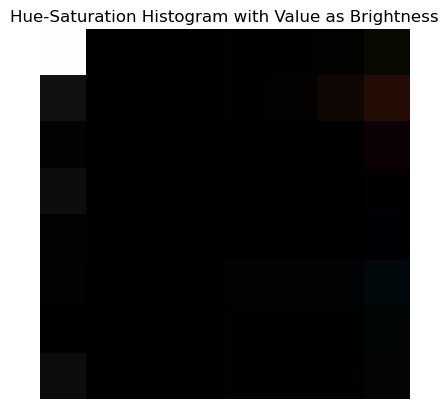

In [97]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('testcut6.jpg')

# Convert to HSV color space
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

resolution = 8

# Calculate the 2D histogram
hist = cv2.calcHist([hsv_image], [0, 1], None, [resolution, resolution], [0, 180, 0, 256])
print(hist)
hist = np.sqrt(hist)

# Normalize the histogram to fit in the display
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

# Create an empty image for the visualization
hist_img = np.zeros((resolution, resolution, 3), dtype=np.uint8)

# Fill the image with the corresponding hue, saturation, and histogram values
for i in range(resolution):
    for j in range(resolution):
        # Map the histogram value to brightness (value channel)
        brightness = int(hist[i, j])
        
        # Calculate the hue and saturation for this cell
        hue = int(180 * (i/resolution) + 90) % 180  # Hue ranges from 0 to 180
        saturation = int(256 * (j/resolution)) # Saturation ranges from 0 to 255
        
        # Set the pixel in the image with the calculated Hue, Saturation, and brightness (Value)
        hist_img[i, j] = [hue, saturation, brightness]

# Convert back to BGR for display
hist_img_bgr = cv2.cvtColor(hist_img, cv2.COLOR_HSV2BGR)

# Plot the result
plt.imshow(hist_img_bgr)
plt.title('Hue-Saturation Histogram with Value as Brightness')
plt.axis('off')  # Hide axis
plt.show()


In [100]:
# TODO: in most images hue and saturation produce almost perfect outlines, segment using these only
# 1. Get hue mask expand it a few pixels out in each direction  (Usually we would use the edges but jpg destroys hue pretty brutally sometimes)
# 2. Get edges of saturation, apply masking                     (For silver keys if theres not enough color contrast, use brightness and pray)
# 3? Maybe some sort of post process pass over dark/bright regions